<a href="https://colab.research.google.com/github/shubhu1026/AI-ML/blob/main/YOLO_TACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

TACO

In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/AI Capstone/Tco.zip'
unzip_dir = '/content/TACO/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Files unzipped successfully!")

Files unzipped successfully!


### Dataset Augmentation

In [ ]:
import cv2
import os
import random
import albumentations as A
from pathlib import Path

# Define the augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Flip the image horizontally
    A.VerticalFlip(p=0.2),  # Flip the image vertically (good for objects visible from multiple angles)
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    A.RandomGamma(p=0.2),  # Adjust image gamma
    A.Rotate(limit=30, p=0.5),  # Random rotation up to 30 degrees
    A.MotionBlur(p=0.1),  # Apply motion blur (simulates camera shake)
    A.GaussNoise(p=0.1),  # Add Gaussian noise (helps with robustness)
    A.Perspective(p=0.2),  # Apply perspective transformation
    A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.2), p=0.3),  # Scale and translation
    A.CLAHE(p=0.1, clip_limit=(1, 4)),  # Adaptive histogram equalization (contrast enhancement)
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),  # Color jitter
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

# Path to your image and label directories
image_dir = Path("/content/TACO/train/images")
label_dir = Path("/content/TACO/train/labels")

# Function to read the YOLO label format
def read_label(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return labels

# Function to write the YOLO label format
def write_label(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(" ".join(label) + '\n')

# Convert YOLO format to Pascal VOC format
def yolo_to_voc(x_center, y_center, width, height, img_width, img_height):
    x_min = (x_center - width / 2) * img_width
    y_min = (y_center - height / 2) * img_height
    x_max = (x_center + width / 2) * img_width
    y_max = (y_center + height / 2) * img_height
    return [x_min, y_min, x_max, y_max]

# Convert Pascal VOC format back to YOLO format
def voc_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height):
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return [x_center, y_center, width, height]

# Augmenting the images and labels
def augment_image(image_path, label_path, output_image_dir, output_label_dir):
    image = cv2.imread(str(image_path))
    img_height, img_width = image.shape[:2]

    labels = read_label(label_path)

    # Convert YOLO format to VOC format for augmentation
    bboxes = []
    category_ids = []
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label)
        bbox = yolo_to_voc(x_center, y_center, width, height, img_width, img_height)
        bboxes.append(bbox)
        category_ids.append(int(class_id))

    # Perform augmentation
    augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)

    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']
    category_ids = augmented['category_ids']

    # Convert back to YOLO format
    new_labels = []
    for i, bbox in enumerate(augmented_bboxes):
        yolo_bbox = voc_to_yolo(bbox[0], bbox[1], bbox[2], bbox[3], img_width, img_height)
        new_labels.append([str(category_ids[i])] + [str(val) for val in yolo_bbox])

    # Save augmented images
    output_image_path = output_image_dir / ("augmented_" + image_path.stem + image_path.suffix)
    cv2.imwrite(str(output_image_path), augmented_image)

    # Save augmented labels
    output_label_path = output_label_dir / ("augmented_" + label_path.stem + label_path.suffix)
    write_label(output_label_path, new_labels)


output_image_dir = image_dir
output_label_dir = label_dir
output_image_dir.mkdir(exist_ok=True)
output_label_dir.mkdir(exist_ok=True)

for image_file in image_dir.glob("*.jpg"):
    label_file = label_dir / (image_file.stem + ".txt")

    if label_file.exists():
        augment_image(image_file, label_file, output_image_dir, output_label_dir)
        print(f"Augmented {image_file.name}")


Augmented 000022_jpg.rf.059a59bf8b662d0a736e485d78ef6a2e.jpg
Augmented 000029_jpg.rf.7087c61341dd6f1f0ca9b5b1368b3073.jpg
Augmented 000087_jpg.rf.b2e42b4b80cde4eb9d02411e5cbb9b87.jpg
Augmented 000051_jpg.rf.10afc8cea82f1745e0fc6c6bc1f6fcfd.jpg
Augmented 000084_jpg.rf.b76c77d994379c024bd3715cdec51ab6.jpg
Augmented 000016_JPG_jpg.rf.694ae18deeea343df7d951a42776dfb2.jpg
Augmented 000060_JPG_jpg.rf.30740610980f924e5b37a11fa9c31090.jpg
Augmented 000054_JPG_jpg.rf.40e1ab6ae454f857634d8acf33d220c1.jpg
Augmented 000039_JPG_jpg.rf.03fa93c3c7b8c91a6f6ff8492e8ec672.jpg
Augmented 000050_jpg.rf.2df352eadac7f4d650fc9d4b32a819d2.jpg
Augmented 000086_jpg.rf.2a02d30f74b3e51baf6249b2fea61bd7.jpg
Augmented 000076_JPG_jpg.rf.9310b9123248d0253797f363383cded7.jpg
Augmented 000032_jpg.rf.9075e5bb14f1a2b2ee4a416177636172.jpg
Augmented 000073_jpg.rf.ebc005f05ff61cda9f2eb9a913fb1ae0.jpg
Augmented 000038_jpg.rf.5e69dc599da91a2a56df17e83ad82013.jpg
Augmented 000086_jpg.rf.b6d52386bf148a904e1ff6af703c364c.jpg
Augm

### Count of Images and Labels after Augmentation

In [ ]:
taco_images_path = "/content/TACO/train/images"

image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tiff"}

num_images = sum(1 for file in os.listdir(taco_images_path) if file.lower().endswith(tuple(image_extensions)))

print(f"Number of TACO images after augmentation: {num_images}")

Number of TACO images after augmentation: 4200


In [ ]:
num_of_labels_after_aug = len(os.listdir("/content/TACO/train/labels"))

print(f"Total no. of labels after augmentation: {num_of_labels_after_aug}")

Total no. of labels after augmentation: 4200


### Sample Images with Bounding Boxes after Augmentaion

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sample_bboxes_TACO(image_dir, label_dir, num_samples=5):
    # Get list of label files
    label_files = [f for f in os.listdir(label_dir) if f.endswith(".txt")]

    # Randomly select a few label files
    selected_labels = random.sample(label_files, min(num_samples, len(label_files)))

    for label_file in selected_labels:
        label_path = os.path.join(label_dir, label_file)
        image_path = os.path.join(image_dir, label_file.replace(".txt", ".jpg"))

        # Skip if image does not exist
        if not os.path.exists(image_path):
            print(f"Skipping {label_file}: Image not found")
            continue

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with open(label_path, "r") as file:
            lines = file.readlines()

        h, w, _ = image.shape

        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.imshow(image)

        for line in lines:
            parts = line.strip().split()
            class_id = int(float(parts[0]))
            x_center, y_center, bbox_width, bbox_height = map(float, parts[1:])

            # Convert YOLO format to pixel values
            x_min = int((x_center - bbox_width / 2) * w)
            y_min = int((y_center - bbox_height / 2) * h)
            bbox_width = int(bbox_width * w)
            bbox_height = int(bbox_height * h)

            # Draw bounding box
            rect = patches.Rectangle(
                (x_min, y_min), bbox_width, bbox_height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f"Class {class_id}", color='red', fontsize=10, backgroundcolor='white')

        # Show the image with bounding boxes
        plt.axis("off")
        plt.show()

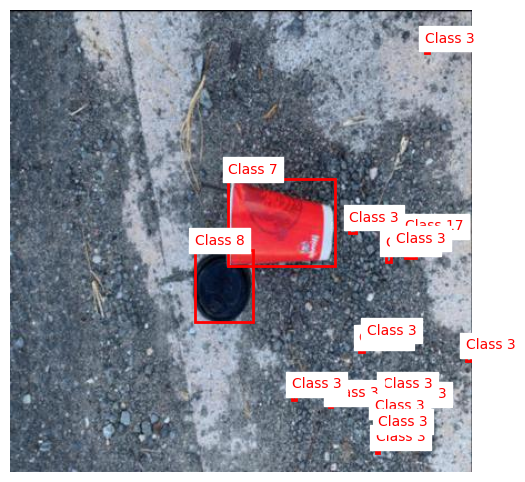

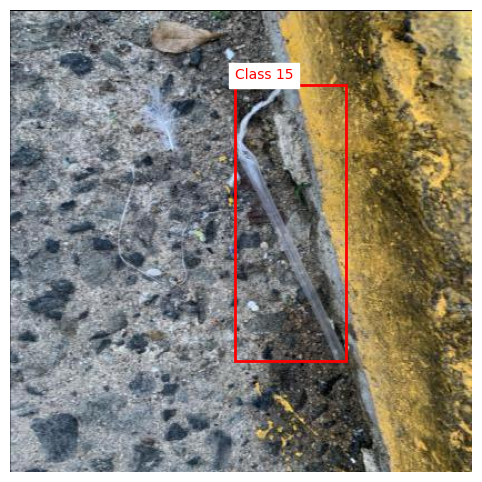

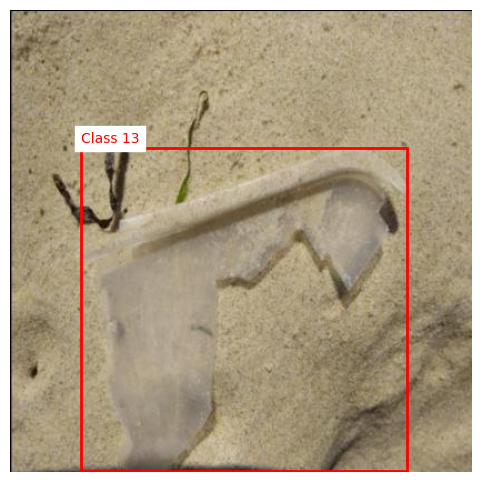

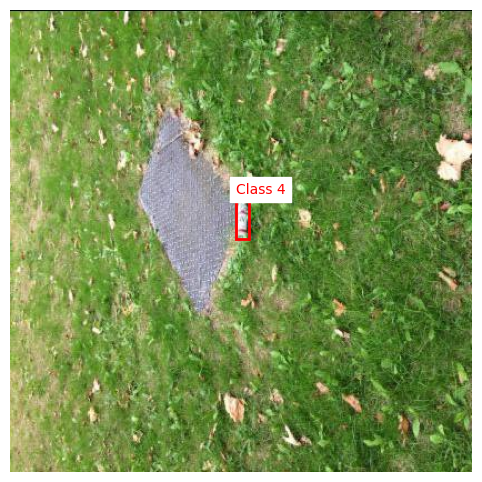

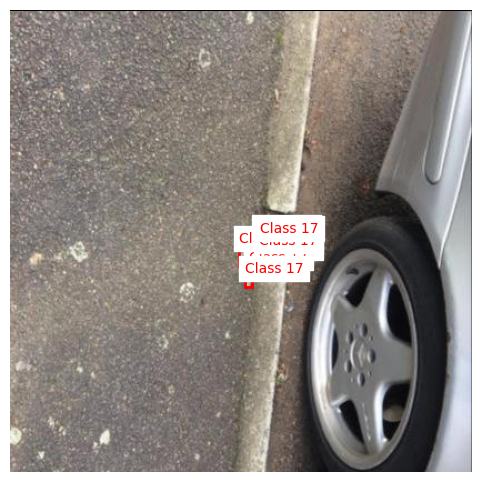

In [ ]:
taco_images_path = "/content/TACO/train/images"
taco_labels_path = "/content/TACO/train/labels"

plot_sample_bboxes_TACO(taco_images_path, taco_labels_path, num_samples=5)

### Training YOLO Model

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.8MB/s]


In [ ]:
results = model.train(
    data="/content/TACO/data.yaml",
    epochs=50,
    patience=5,
    lr0=0.00001,
    save=True,
    pretrained=False,
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/TACO/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]


Overriding model.yaml nc=80 with nc=18

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/TACO/train/labels... 4200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4200/4200 [00:01<00:00, 2301.72it/s]

train: New cache created: /content/TACO/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/TACO/valid/labels... 1704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1704/1704 [00:01<00:00, 1111.24it/s]

val: New cache created: /content/TACO/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.66G       1.38      4.267      1.255         52        640: 100%|██████████| 263/263 [01:28<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:17<00:00,  3.16it/s]


                   all       1704       4830      0.225      0.129     0.0453     0.0294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.93G      1.401      3.499      1.253         44        640: 100%|██████████| 263/263 [01:22<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.40it/s]


                   all       1704       4830      0.204      0.168     0.0697     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.94G      1.371      3.228      1.233         42        640: 100%|██████████| 263/263 [01:20<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]


                   all       1704       4830      0.249      0.176     0.0914     0.0593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.96G      1.384      2.979      1.234         47        640: 100%|██████████| 263/263 [01:22<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.33it/s]


                   all       1704       4830      0.266      0.182      0.111     0.0726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.96G      1.352      2.764      1.222         26        640: 100%|██████████| 263/263 [01:21<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.37it/s]


                   all       1704       4830      0.276      0.184       0.11     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.99G      1.329      2.627      1.215        100        640: 100%|██████████| 263/263 [01:20<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.36it/s]


                   all       1704       4830      0.293      0.201      0.132     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         4G      1.315      2.527      1.198         18        640: 100%|██████████| 263/263 [01:20<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.40it/s]


                   all       1704       4830      0.283      0.209      0.145     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.01G      1.293      2.403      1.183         22        640: 100%|██████████| 263/263 [01:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]


                   all       1704       4830      0.291      0.213      0.158      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.02G      1.273      2.277      1.174         79        640: 100%|██████████| 263/263 [01:19<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.21it/s]


                   all       1704       4830      0.312      0.238      0.173       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.04G      1.263      2.214      1.172         47        640: 100%|██████████| 263/263 [01:19<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.41it/s]


                   all       1704       4830      0.316      0.226      0.159      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.06G      1.243      2.114      1.165         73        640: 100%|██████████| 263/263 [01:20<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.43it/s]


                   all       1704       4830      0.312      0.247      0.185      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.07G      1.233      2.052      1.147         31        640: 100%|██████████| 263/263 [01:20<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.36it/s]


                   all       1704       4830      0.314      0.236      0.186      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.08G      1.215      1.955      1.148         37        640: 100%|██████████| 263/263 [01:20<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.43it/s]


                   all       1704       4830      0.327      0.242      0.186      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       4.1G      1.197      1.896      1.138         29        640: 100%|██████████| 263/263 [01:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.49it/s]


                   all       1704       4830      0.358       0.26      0.213      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.12G      1.193      1.824      1.127         16        640: 100%|██████████| 263/263 [01:18<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.23it/s]


                   all       1704       4830       0.34      0.259      0.217      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.13G      1.187      1.773      1.127         15        640: 100%|██████████| 263/263 [01:16<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.49it/s]


                   all       1704       4830      0.387       0.26      0.227      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.14G      1.167      1.707      1.109         32        640: 100%|██████████| 263/263 [01:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


                   all       1704       4830      0.374      0.253      0.224      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.16G       1.17      1.638      1.111         35        640: 100%|██████████| 263/263 [01:17<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.38it/s]


                   all       1704       4830      0.517      0.235      0.252      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.18G      1.146      1.574      1.101         26        640: 100%|██████████| 263/263 [01:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.37it/s]


                   all       1704       4830      0.427      0.266      0.247      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.19G      1.156      1.561      1.105         24        640: 100%|██████████| 263/263 [01:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


                   all       1704       4830       0.45      0.273      0.262       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       4.2G      1.137      1.503      1.091         16        640: 100%|██████████| 263/263 [01:17<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.46it/s]


                   all       1704       4830      0.361      0.279      0.255      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.22G      1.124      1.456      1.095         54        640: 100%|██████████| 263/263 [01:16<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.38it/s]


                   all       1704       4830      0.374       0.28      0.263      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.23G      1.108      1.393       1.09         64        640: 100%|██████████| 263/263 [01:16<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


                   all       1704       4830      0.481      0.285      0.285      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.25G      1.108      1.368       1.08         36        640: 100%|██████████| 263/263 [01:17<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.44it/s]


                   all       1704       4830      0.428        0.3      0.289      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.25G      1.076      1.309      1.068         44        640: 100%|██████████| 263/263 [01:17<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.50it/s]


                   all       1704       4830       0.46       0.29      0.289      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.28G      1.091        1.3      1.073         33        640: 100%|██████████| 263/263 [01:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.54it/s]


                   all       1704       4830      0.543      0.289      0.307      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.29G      1.078      1.246      1.064         37        640: 100%|██████████| 263/263 [01:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.33it/s]


                   all       1704       4830       0.53      0.297       0.31       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.31G      1.069      1.218      1.058         45        640: 100%|██████████| 263/263 [01:16<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


                   all       1704       4830      0.508      0.292      0.311      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.31G      1.057      1.188      1.058         27        640: 100%|██████████| 263/263 [01:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.52it/s]


                   all       1704       4830      0.472      0.309      0.311      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.33G      1.065      1.165      1.054         23        640: 100%|██████████| 263/263 [01:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.37it/s]


                   all       1704       4830      0.481      0.307      0.322      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.35G      1.032      1.118      1.042         28        640: 100%|██████████| 263/263 [01:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.49it/s]


                   all       1704       4830      0.527      0.293      0.318      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.36G      1.033      1.108      1.047         52        640: 100%|██████████| 263/263 [01:17<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


                   all       1704       4830      0.497      0.316      0.326      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.37G      1.029      1.089      1.044         26        640: 100%|██████████| 263/263 [01:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.22it/s]


                   all       1704       4830      0.501      0.316      0.327      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.39G      1.036      1.073      1.038         29        640: 100%|██████████| 263/263 [01:16<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


                   all       1704       4830      0.531      0.318      0.338      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.41G      1.023      1.069      1.042         33        640: 100%|██████████| 263/263 [01:18<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


                   all       1704       4830       0.53      0.315      0.331      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.42G      1.017      1.031      1.034         34        640: 100%|██████████| 263/263 [01:17<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.32it/s]


                   all       1704       4830      0.561      0.325      0.344       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.43G       0.99     0.9941      1.022         58        640: 100%|██████████| 263/263 [01:16<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.42it/s]


                   all       1704       4830      0.564       0.31       0.34      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.45G     0.9939     0.9832       1.02         26        640: 100%|██████████| 263/263 [01:17<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.42it/s]


                   all       1704       4830      0.556      0.315      0.341      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.47G     0.9796     0.9643      1.022         29        640: 100%|██████████| 263/263 [01:17<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.23it/s]


                   all       1704       4830      0.535      0.335       0.35      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.48G     0.9712     0.9394      1.017         46        640: 100%|██████████| 263/263 [01:15<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


                   all       1704       4830      0.514      0.321      0.345      0.256
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.49G     0.9321     0.8876     0.9783         21        640: 100%|██████████| 263/263 [01:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


                   all       1704       4830      0.535      0.336      0.354      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.51G     0.9081     0.8155     0.9662         18        640: 100%|██████████| 263/263 [01:12<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.49it/s]


                   all       1704       4830      0.509      0.348      0.358      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.53G     0.8959     0.7888     0.9593         52        640: 100%|██████████| 263/263 [01:13<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.26it/s]


                   all       1704       4830      0.556       0.34      0.362      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.54G     0.8952     0.7754     0.9567         31        640: 100%|██████████| 263/263 [01:14<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:23<00:00,  2.28it/s]


                   all       1704       4830      0.583      0.341      0.364      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.55G     0.8849     0.7479     0.9541         20        640: 100%|██████████| 263/263 [01:13<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.32it/s]


                   all       1704       4830      0.504      0.363      0.369      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.57G     0.8843     0.7391     0.9481         17        640: 100%|██████████| 263/263 [01:13<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.39it/s]


                   all       1704       4830      0.558      0.347      0.366      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.59G     0.8759     0.7346     0.9502         17        640: 100%|██████████| 263/263 [01:13<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.50it/s]


                   all       1704       4830       0.57       0.34      0.368       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       4.6G     0.8681       0.72     0.9389         30        640: 100%|██████████| 263/263 [01:13<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.46it/s]


                   all       1704       4830      0.521       0.36      0.371      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.61G     0.8677     0.7182     0.9485         24        640: 100%|██████████| 263/263 [01:13<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:16<00:00,  3.29it/s]


                   all       1704       4830      0.569      0.346      0.371      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.63G     0.8539     0.7006     0.9391         11        640: 100%|██████████| 263/263 [01:12<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.54it/s]


                   all       1704       4830      0.533      0.359      0.373      0.284

50 epochs completed in 1.312 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:17<00:00,  3.05it/s]


                   all       1704       4830      0.534      0.358      0.373      0.284
        Aluminium foil         48         62      0.779      0.516      0.522      0.422
            Bottle cap        347        459      0.542      0.669      0.634      0.499
                Bottle        275        320      0.749      0.419      0.481       0.31
          Broken glass         13        123      0.149      0.065     0.0521     0.0245
                   Can        187        267      0.661      0.659      0.684      0.541
                Carton        207        263      0.514      0.534      0.532      0.447
             Cigarette        223        565      0.518      0.126      0.148     0.0713
                   Cup        162        186      0.553      0.548      0.576      0.457
                   Lid         82         93      0.582      0.312      0.359      0.285
          Other litter        148        178      0.631      0.264      0.301       0.24
         Other plasti

In [ ]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

results = model.train(
    data="/content/TACO/data.yaml",
    epochs=50,
    patience=5,
    lr0=0.00001,
    save=True,
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/TACO/data.yaml, epochs=50, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /content/TACO/train/labels.cache... 4200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4200/4200 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/TACO/valid/labels.cache... 1704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1704/1704 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.12G     0.9588     0.9236      1.012         52        640: 100%|██████████| 263/263 [01:25<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:14<00:00,  3.65it/s]


                   all       1704       4830      0.502      0.341      0.356      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.35G      1.001      1.011      1.031         44        640: 100%|██████████| 263/263 [01:20<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.56it/s]


                   all       1704       4830      0.578      0.288       0.32      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.35G      1.045      1.126      1.041         42        640: 100%|██████████| 263/263 [01:18<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.57it/s]


                   all       1704       4830      0.498      0.302      0.284      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.35G      1.085      1.188       1.06         47        640: 100%|██████████| 263/263 [01:20<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:14<00:00,  3.65it/s]


                   all       1704       4830      0.484      0.274      0.281      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.35G      1.083      1.185      1.063         26        640: 100%|██████████| 263/263 [01:21<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.57it/s]


                   all       1704       4830      0.454       0.28      0.275      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.35G      1.083      1.171       1.07        100        640: 100%|██████████| 263/263 [01:17<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:15<00:00,  3.55it/s]


                   all       1704       4830       0.47      0.307      0.306       0.22
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

6 epochs completed in 0.162 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:18<00:00,  2.97it/s]


                   all       1704       4830      0.507      0.339      0.355      0.265
        Aluminium foil         48         62      0.877      0.461      0.528      0.417
            Bottle cap        347        459       0.51      0.645       0.61      0.464
                Bottle        275        320      0.699      0.388      0.468      0.298
          Broken glass         13        123      0.204     0.0488     0.0489     0.0284
                   Can        187        267      0.677      0.618      0.678      0.532
                Carton        207        263      0.541      0.483      0.511      0.408
             Cigarette        223        565      0.504      0.103       0.14     0.0701
                   Cup        162        186      0.363      0.527      0.504      0.403
                   Lid         82         93      0.391      0.386      0.333      0.262
          Other litter        148        178      0.558      0.258      0.294      0.223
         Other plasti

In [ ]:
results = model.val()

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,585,662 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/TACO/valid/labels.cache... 1704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1704/1704 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 107/107 [00:21<00:00,  4.94it/s]


                   all       1704       4830      0.507      0.339      0.356      0.266
        Aluminium foil         48         62      0.877      0.461      0.528       0.42
            Bottle cap        347        459      0.511      0.643      0.611      0.463
                Bottle        275        320      0.696      0.388      0.467        0.3
          Broken glass         13        123      0.197     0.0488     0.0489     0.0284
                   Can        187        267      0.675      0.618      0.678      0.532
                Carton        207        263      0.538      0.483      0.511      0.411
             Cigarette        223        565       0.51      0.101      0.144      0.071
                   Cup        162        186      0.365      0.527      0.504      0.404
                   Lid         82         93      0.391      0.386      0.333      0.261
          Other litter        148        178      0.563      0.258      0.293      0.226
         Other plasti